In [1]:
#Import all the depenencies
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

In [2]:
#Set all the Constants
INIT_LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 50
IMAGE_SIZE = 256
default_image_size = tuple((IMAGE_SIZE, IMAGE_SIZE))
image_size = 0
data_dir = "C:/Users/prana/Downloads/task/wbc"
CHANNELS=3
AUTOTUNE = tf.data.AUTOTUNE

In [3]:
#Initializing, Exploring & Partioning the Dataset
#Function to Split Dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = ds.cardinality().numpy()
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [4]:
#Reading and Partitioning the Dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=default_image_size,
  batch_size=BATCH_SIZE
)


train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

Found 528 files belonging to 9 classes.


In [5]:
#Checking the Available Classes
class_names = dataset.class_names
n_classes = len(class_names)
print(n_classes, class_names)

9 ['bands', 'basophils', 'blasts', 'eosinophils', 'lymphocytes', 'metamyelocytes', 'monocytes', 'myelocytes', 'neutrophils']


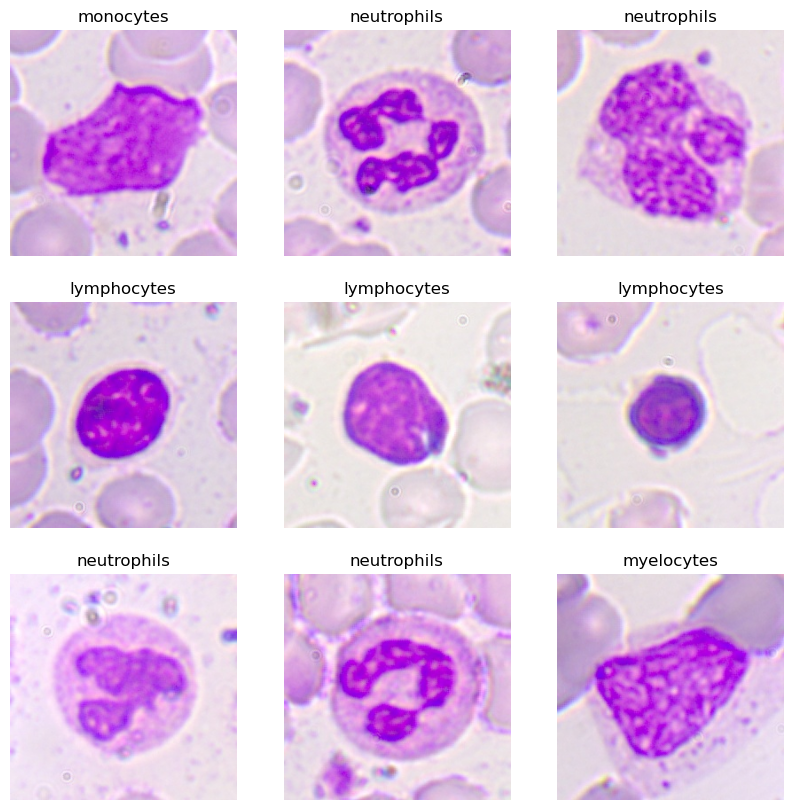

In [6]:
#Displaying Some Sample Images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
#Checking Batch Size
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [8]:
#Cache, Shuffle, and Prefetch the Dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [9]:
#Building the Model
#Creating a Layer for Resizing and Normalization
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [10]:
#Data Augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [11]:
#Checking what is the expected dimension order for channel
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
chanDim = -1
if K.image_data_format() == "channels_first":
    input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    chanDim = 1

In [12]:
#Model Architecture
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=batch_input_shape)

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [14]:
#Compiling the Model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [15]:
#Training the Network
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
13/13 [==============================] - 41s 3s/step - loss: 1.6391 - accuracy: 0.3875 - val_loss: 1.2343 - val_accuracy: 0.4375
Epoch 2/50
13/13 [==============================] - 32s 2s/step - loss: 1.4966 - accuracy: 0.3800 - val_loss: 1.2462 - val_accuracy: 0.4375
Epoch 3/50
13/13 [==============================] - 29s 2s/step - loss: 1.4621 - accuracy: 0.4850 - val_loss: 1.2656 - val_accuracy: 0.4375
Epoch 4/50
13/13 [==============================] - 29s 2s/step - loss: 1.4373 - accuracy: 0.5075 - val_loss: 1.2123 - val_accuracy: 0.7500
Epoch 5/50
13/13 [==============================] - 34s 3s/step - loss: 1.3465 - accuracy: 0.6075 - val_loss: 1.0452 - val_accuracy: 0.7500
Epoch 6/50
13/13 [==============================] - 31s 2s/step - loss: 1.2069 - accuracy: 0.6750 - val_loss: 0.8677 - val_accuracy: 0.7812
Epoch 7/50
13/13 [==============================] - 32s 2s/step - loss: 1.0154 - accuracy: 0.7200 - val_loss: 0.8536 - val_accuracy: 0.8438
Epoch 8/50
13/13 [==

In [19]:
#Testing the Model
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating model accuracy
3/3 [==============================] - 2s 532ms/step - loss: 0.4504 - accuracy: 0.8542
Test Accuracy: 85.42%


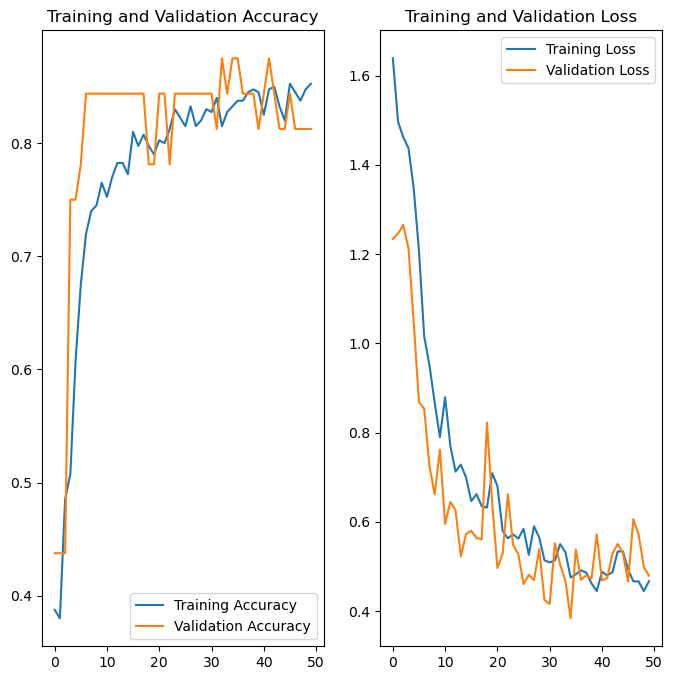

In [17]:
#Plotting the Accuracy and Loss Curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
#Saving the Model
import os
model_version = max([int(i) for i in (os.listdir("C:/Users/prana/Downloads/task/wbcmodel")+[0])]) + 1
model.save(f"C:/Users/prana/Downloads/task/wbcmodel{model_version}")

INFO:tensorflow:Assets written to: C:/Users/prana/Downloads/task/wbcmodel1\assets


INFO:tensorflow:Assets written to: C:/Users/prana/Downloads/task/wbcmodel1\assets


In [22]:
#Function for Inference
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 78ms/step


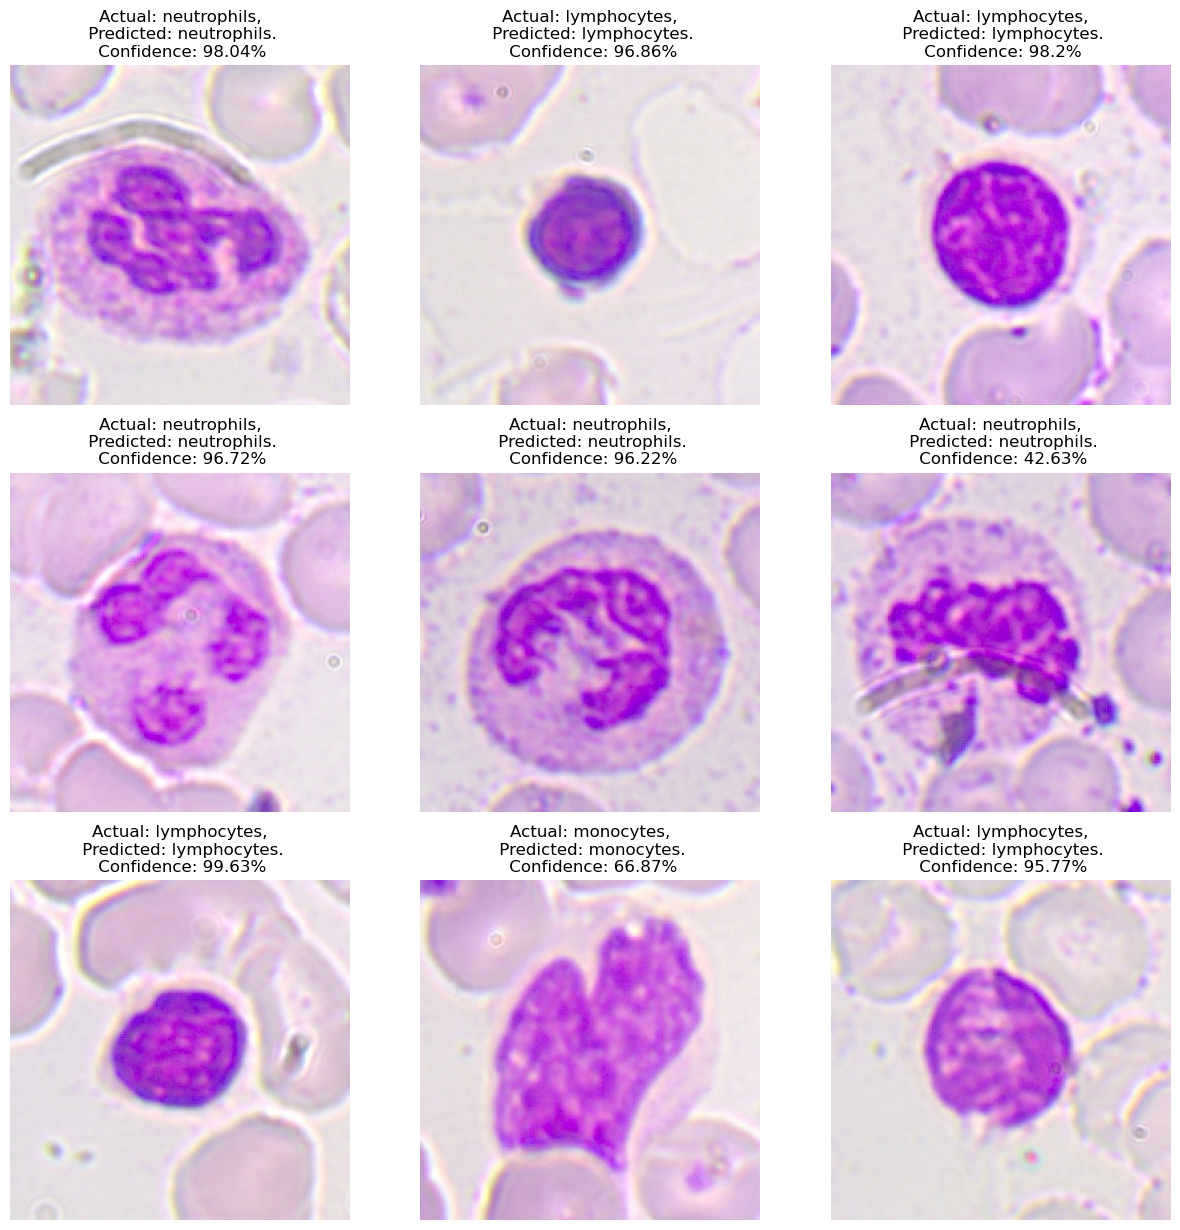

In [23]:
#Plotting the Inference Data
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_names[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [26]:
#Saving the model
model.save("C:/Users/prana/Downloads/task/wbcmodel")

INFO:tensorflow:Assets written to: C:/Users/prana/Downloads/task/wbcmodel\assets


INFO:tensorflow:Assets written to: C:/Users/prana/Downloads/task/wbcmodel\assets
